# Données spatiales: découverte de geopandas

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/manipulation%2003_geopandas_tutorial.ipynb%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=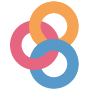" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

Dans ce tutoriel, nous allons utiliser:

-   [Localisations des stations velib](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
-   [Carte des limites administratives françaises](https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12)
-   [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

La représentation des données, notamment la cartographie, est présentée plus
amplement dans la partie [visualiser](#visualiser). Quelques méthodes
pour faire rapidement des cartes seront présentées ici mais
ce n’est pas l’objet de ce chapitre.

Ce tutoriel s’inspire beaucoup d’un autre tutoriel que j’ai fait pour
`R` disponible
[dans la documentation `utilitr`](https://www.book.utilitr.org/spatdata.html).
Il peut servir de pendant à celui-ci pour l’utilisateur de `R`.

Quelques installations préalables sont nécessaires :

``` python
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
```

Pour être en mesure d’exécuter ce tutoriel, les imports suivants
seront utiles.

In [2]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Données spatiales: quelle différence avec des données traditionnelles ?

**Le terme “données spatiales” désigne les données qui portent sur les caractéristiques géographiques des objets (localisation, contours, liens)**. Les caractéristiques géographiques des objets sont décrites à l’aide d’un **système de coordonnées**
qui permettent une représentation dans un espace euclidien ($(x,y)$).
Le passage de l’espace réel (la Terre, qui est une sphère) à l’espace plan
se fait grâce à un **système de projection**. Voici quelques exemples
de données spatiales:

-   Une table décrivant des bâtiments, avec les coordonnées géographiques de chaque bâtiment;
-   Le découpage communal du territoire, avec le contour du territoire de chaque commune;
-   Les routes terrestres, avec les coordonnées décrivant leur parcours.

Les données spatiales rassemblent classiquement deux types de données :

1.  des **données géographiques** (ou géométries): objets géométriques tels que des points, des vecteurs, des polygones, ou des maillages (*raster*). Exemple: la forme de chaque chaque commune, les coordonnées d’un bâtiment;
2.  des **données attributaires** (ou attributs): des mesures et des caractéristiques associés aux objets géométriques. Exemple: la population de chaque commune, le nombre de fenêtres et le nombre d’étages d’un bâtiment.

**Les données spatiales sont fréquemment traitées à l’aide d’un système d’information géographique (SIG)**, c’est-à-dire un système d’information capable de stocker, d’organiser et de présenter des données alphanumériques spatialement référencées par des coordonnées dans un système de référence (CRS). `Python` dispose de fonctionnalités lui permettant de réaliser les mêmes tâches qu’un SIG (traitement de données spatiales, représentations cartographiques).

**Les systèmes de projection font l’objet de standards internationaux et sont souvent désignés par des codes dits codes EPSG**. Ce [site](https://epsg.io/) est un bon aide-mémoire. Les plus fréquents, pour les utilisateurs français, sont les suivants (plus d’infos [ici](https://geodesie.ign.fr/contenu/fichiers/documentation/SRCfrance.pdf)):

-   `2154`: système de projection Lambert 93. Il s’agit du système de projection officiel. La plupart des données diffusées par l’administration pour la métropole sont disponibles dans ce système de projection.
-   `27572`: Lambert II étendu. Il s’agit de l’ancien système de projection officiel. Les données spatiales anciennes peuvent être dans ce format.
-   `4326`: WGS 84 ou système de pseudo-Mercator. Attention, ce n’est en réalité pas un système de projection mais un système de coordonnées (longitude / latitude) qui permet simplement un repérage angulaire sur l’ellipsoïde. Il est utilisé pour les données GPS.

## De `pandas` à `geopandas`

Le *package* `geopandas` est une boîte à outils conçue pour faciliter la manipulation de données spatiales. **La grande force de `geopandas` est qu’il permet de manipuler des données spatiales comme s’il s’agissait de données traditionnelles**, car il repose sur le standard ISO 19125 [*simple feature access*](https://en.wikipedia.org/wiki/Simple_Features) défini conjointement par l’*Open Geospatial Consortium (OGC)* et l’*International Organization for Standardization (ISO)*.

Par rapport à un DataFrame standard, un objet `geopandas` comporte
une colonne supplémentaire: `geometry`. Elle stocke les coordonnées des
objets géographiques (ou ensemble de coordonnées s’agissant de contours). Un objet `geopandas` hérite des propriétés d’un
DataFrame pandas mais propose des méthodes adaptées au traitement des données spatiales.

Ainsi, grâce à `geopandas`, on pourra effectuer des manipulations sur les attributs des données comme avec `pandas` mais on pourra également faire des manipulations sur la dimension spatiale des données. En particulier,

-   Calculer des distances et des surfaces;
-   Agréger rapidement des zonages (regrouper les communes en département par exemple);
-   Trouver dans quelle commune se trouve un bâtiment à partir de ses coordonnées géographiques;
-   Recalculer des coordonnées dans un autre système de projection.
-   Faire une carte, rapidement et simplement

{{% box status=“hint” title=“Conseil” icon=“fa fa-lightbulb” %}}
Les manipulations de données sur un objet geopandas sont nettement plus lentes que sur un DataFrame traditionnel (car python doit gérer les informations géographiques pendant la manipulation des données). Lorsque vous manipulez des données de grandes dimensions, il peut être préférable d’effectuer les opérations sur les données avant de joindre une géométrie à celles-ci.
{{% /box %}}

Par rapport à un logiciel spécialisé comme `QGIS`, `python` permettra
d’automatiser le traitement et la représentation des données. D’ailleurs,
`QGIS` utilise lui-même `python`…

# Importer des données spatiales

Les données spatiales sont plus riches que les données traditionnelles car elles
incluent, habituellement, des éléments supplémentaires pour placer dans
un espace cartésien les objets. Cette dimension supplémentaire peut être simple
(un point comporte deux informations supplémentaire: $x$ et $y$) ou
assez complexe (polygones, lignes avec direction, etc.)

Les formats les plus communs de données spatiales sont les suivants:

-   *shapefile* (`.shp`): format (**propriétaire**) le plus commun de données géographiques.
    La table de données (attributs) est stockée dans un fichier séparé des
    données spatiales. En faisant `geopandas.read_file("monfichier.shp")`, le
    package fait lui-même le lien entre les observations et leur représentation spatiale ;
-   *geojson* (`.json`) : ce format, non préconisé par l’OGC est largement utilisé pour le développement web comme dans la librairie `Leaflet`. La dimension spatiale est stockée dans le même fichier que les attributs. Ces fichiers sont généralement beaucoup plus légers que les *shapefiles* mais possèdent des limites s’agissant de gros jeux de données.
-   *geopackage* (`.gpkg`) : ce (relativement) nouveau format **libre** en un seul fichier également (lui recommandé par l’OGC) vise progressivement à se substituer au shapefile. Il est par exemple le format par défaut dans QGIS.

Cette [page](https://si.ecrins-parcnational.com/blog/2020-02-geojson-shapefile-geopackage.html) compare plus en détail ces trois types de formats de données géographiques.

L’aide de [geopandas](https://geopandas.org/io.html) propose des bouts de code en fonction des différentes situations dans lesquelles on se trouve.

### Exemple: récupérer les découpages territoriaux

L’un des fonds de carte les plus fréquents qu’on utilise est celui des
limites administratives. Elles peuvent être trouvées sur le
[site de l’IGN](https://geoservices.ign.fr/adminexpress#telechargementCog) ou récupérées sur
[data.gouv](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/) (construites par `openstreetmap`).
Il est également possible d’utiliser l’une des [API de l’IGN](https://api.gouv.fr/les-api/api_carto_cadastre)
mais ces dernières ne sont pas encore très documentées pour des utilisateurs
de `Python`.

Nous allons utiliser le package `pynsee` qui propose un module dédié à la récupération de fonds de carte officiels pour valoriser des données
d’open data. Une précédente version de ce cours utilisait les données de
`data.gouv`, elle est reportée en annexe

L’inconvénient est que les arrondissements
parisiens ne sont pas présents dans le fichier proposé sur `data.gouv`. Il
faut donc utiliser une source complémentaire, issue de l’*opendata* de la
Mairie de Paris.

In [3]:
from pynsee.geodata import get_geodata
shp_communes = gpd.GeoDataFrame(
  get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')
)
shp_communes = shp_communes.rename({"insee_com": 'insee'}, axis = 'columns')
shp_communes = shp_communes.set_crs(3857)

In [4]:
shp_communes.head()

id 
 nom 
 nom_m 
 insee 
 statut 
 population 
 insee_can 
 insee_arr 
 insee_dep 
 insee_reg 
 siren_epci 
 geometry 
 bbox 
 crs 
 
 
 
 
 0 
 COMMUNE_0000001269976025 
 Le Diamant 
 LE DIAMANT 
 97206 
 Commune simple 
 5511 
 NR 
 3 
 972 
 02 
 249720053 
 MULTIPOLYGON (((-6794714.852 1625025.923, -679... 
 [-6796892.81639186, 1624969.98776564, -6788212... 
 EPSG:3857 
 
 
 1 
 COMMUNE_0000001269976026 
 Les Anses-d'Arlet 
 LES ANSES-D'ARLET 
 97202 
 Commune simple 
 3494 
 NR 
 3 
 972 
 02 
 249720053 
 MULTIPOLYGON (((-6796770.257 1632364.571, -679... 
 [-6801724.22854182, 1626341.46982216, -6795643... 
 EPSG:3857 
 
 
 2 
 COMMUNE_0000001269976019 
 Rivière-Salée 
 RIVIERE-SALEE 
 97221 
 Commune simple 
 11874 
 NR 
 3 
 972 
 02 
 249720053 
 MULTIPOLYGON (((-6788283.345 1637546.648, -678... 
 [-6790993.527111, 1631234.68464338, -6781597.8... 
 EPSG:3857 
 
 
 3 
 COMMUNE_0000001269975998 
 Saint-Pierre 
 SAINT-PIERRE 
 97225 
 Sous-préfecture 
 4121 
 NR 
 4 
 972 
 02 
 200041788 
 MULTIPOLYGON (((-6814293.278 1664074.082, -681... 
 [-6814293.27835075, 1657968.05307498, -6805323... 
 EPSG:3857 
 
 
 4 
 COMMUNE_0000001269975994 
 Sainte-Marie 
 SAINTE-MARIE 
 97228 
 Commune simple 
 15487 
 NR 
 2 
 972 
 02 
 200041788 
 MULTIPOLYGON (((-6786330.097 1662972.643, -678... 
 [-6796534.21176401, 1658613.16621139, -6786313... 
 EPSG:3857

On reconnaît la structure d’un DataFrame pandas. A cette structure s’ajoute
une colonne `geometry` qui enregistre la position des limites des polygones de chaque
observation.

Comme vu précédemment, le système de projection est un élément important. Il permet à `python`
d’interpréter les valeurs des points (deux dimensions) en position sur
la terre, qui n’est pas un espace plan. Ici, les données ne sont pas projetées puisqu’elles sont dans le
système WSG84 (epsg: 4326) ce qui permet de facilement ajouter
un fonds de carte `openstreetmap` ou `stamen` pour rendre une représentation
graphique plus esthétique. En toute rigueur, pour faire une carte statique d’un pays en particulier, il faudrait reprojeter les données dans un système de projection adapté à la zone géographique étudiée (par exemple le Lambert-93 pour la France métropolitaine).

On peut ainsi représenter Paris pour se donner une idée de la nature
du shapefile utilisé :

<AxesSubplot:>

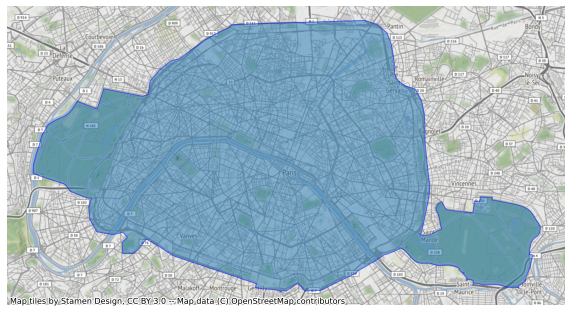

In [5]:
paris = shp_communes.loc[shp_communes['insee'].str.startswith("75")]

fig,ax = plt.subplots(figsize=(10, 10))
paris.plot(ax = ax, alpha=0.5, edgecolor='blue')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

On voit ainsi que les données pour Paris ne comportent pas d’arrondissement,
ce qui est limitant pour une analyse focalisée sur Paris. On va donc les
récupérer sur le site d’open data de la ville de Paris et les substituer
à Paris :

En refaisant la carte ci-dessus, on obtient bien, cette fois, le résultat
espéré

<AxesSubplot:>

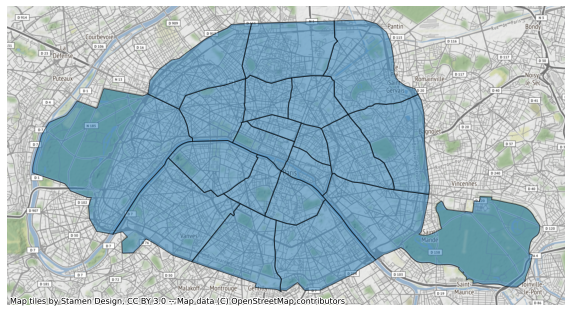

In [7]:
paris = communes.loc[communes.insee.str.startswith("75")]

fig,ax = plt.subplots(figsize=(10, 10))

paris.plot(ax = ax, alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

# Opérations sur les attributs et les géométries

## Import des données velib

Souvent, le découpage communal ne sert qu’en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données. On va partir des données de localisation des
stations velib,
disponibles [sur le site d’open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et
requêtables directement par l’url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

In [9]:
communes['dep'] = communes.insee.str[:2]

On peut se rassurer en affichant les données sur la carte des communes d’Île-de-France.

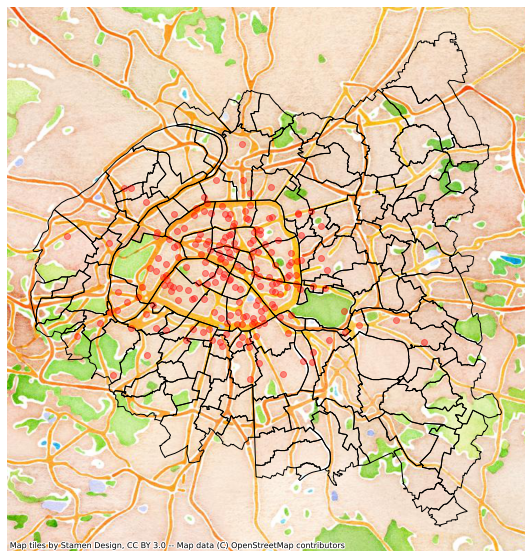

Découvrez ci-dessous par étape les différentes lignes de commandes permettant d’afficher cette carte complète,
étape par étape:

:one:
Afficher le nuage de points de 200 stations vélibs prises au hasard

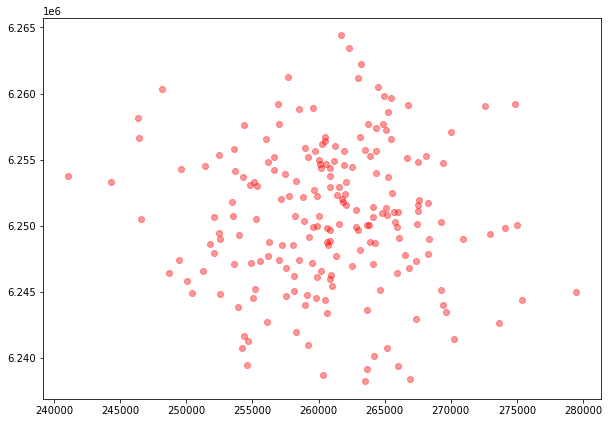

:two:
Ajouter à cette couche, en dessous, les contours des communes

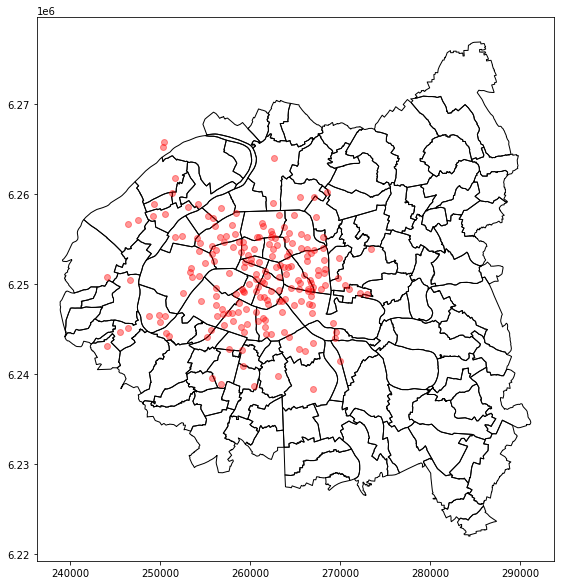

:three:
Ajouter un fond de carte de type *open street map* grâce au package
`contextily`

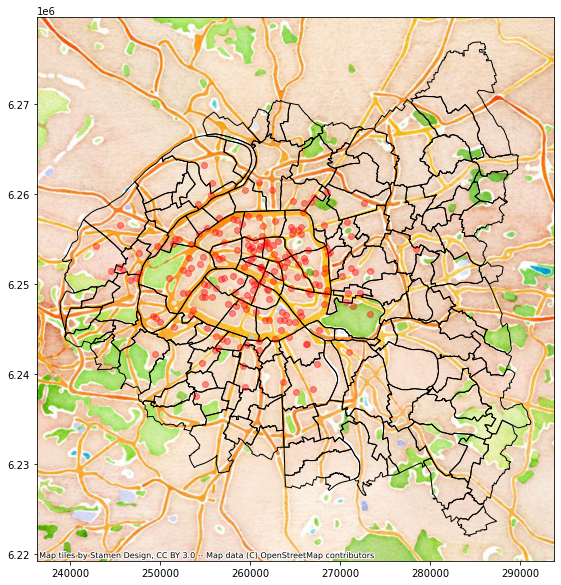

:four:
Ne reste plus qu’à retirer l’axe des coordonnées, qui n’est pas très
esthétique. Pour cela:

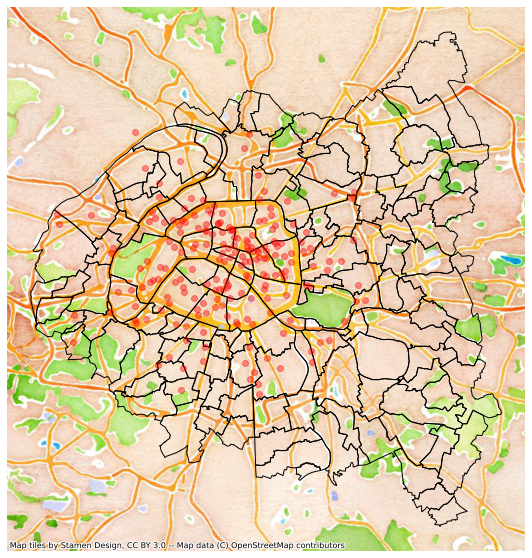

*In fine*, on obtient la carte désirée.

## Opérations sur les attributs

Toutes les opérations possibles sur un objet `pandas` le sont également
sur un objet `geopandas`. Pour manipuler les données, et non la géométrie,
on parlera d’opérations sur les attributs.

Par exemple, si on désire
connaître quelques statistiques sur la taille des stations:

In [20]:
stations.describe()

capacity 
 
 
 
 
 count 
 1438.000000 
 
 
 mean 
 31.307371 
 
 
 std 
 11.954511 
 
 
 min 
 0.000000 
 
 
 25% 
 23.000000 
 
 
 50% 
 29.000000 
 
 
 75% 
 37.000000 
 
 
 max 
 74.000000

Pour connaître les plus grands départements, créons d’abord les deux variables en question: le département (deux premiers chiffres du code Insee) et surface (méthode `area` sur un objet `geopandas.GeoDataFrame` ramenée en km², attention néamoins au système de projection comme cela est expliqué plus bas):

In [21]:
shp_communes['dep'] = shp_communes.insee.str[:2]
shp_communes['surface'] = shp_communes.area.div(10**6)

Les plus grands départements s’obtiennent par une aggrégation des
surfaces communales:

In [22]:
shp_communes.groupby('dep').sum().sort_values('surface', ascending = False)

population 
 surface 
 
 
 dep 
 
 
 
 
 
 
 97 
 2148153 
 90325.703220 
 
 
 33 
 1623749 
 20045.169670 
 
 
 21 
 534124 
 19220.605118 
 
 
 51 
 566855 
 18987.804188 
 
 
 24 
 413223 
 18513.452891 
 
 
 ... 
 ... 
 ... 
 
 
 90 
 141318 
 1344.702988 
 
 
 94 
 1407124 
 563.446720 
 
 
 93 
 1644903 
 548.083287 
 
 
 92 
 1624357 
 405.163743 
 
 
 75 
 2165423 
 243.369921 
 
 
 
 97 rows × 2 columns

Si on veut directement les plus
grandes communes de France métropolitaine :

In [23]:
shp_communes[shp_communes.dep != "97"].sort_values('surface', ascending = False)

id 
 nom 
 nom_m 
 insee 
 statut 
 population 
 insee_can 
 insee_arr 
 insee_dep 
 insee_reg 
 siren_epci 
 geometry 
 bbox 
 crs 
 dep 
 surface 
 
 
 
 
 22840 
 COMMUNE_0000000009760125 
 Arles 
 ARLES 
 13004 
 Sous-préfecture 
 50454 
 04 
 2 
 13 
 93 
 241300417 
 MULTIPOLYGON (((529716.432 5418497.982, 529760... 
 [492722.21254763, 5362141.57240412, 542833.049... 
 EPSG:3857 
 13 
 1441.169097 
 
 
 30797 
 COMMUNE_0000000009753237 
 Val-Cenis 
 VAL-CENIS 
 73290 
 Commune simple 
 2062 
 10 
 3 
 73 
 84 
 200070340 
 MULTIPOLYGON (((784923.433 5657103.171, 784494... 
 [749405.2238272, 5641582.09681337, 784923.4330... 
 EPSG:3857 
 73 
 921.013518 
 
 
 23217 
 COMMUNE_0000000009760352 
 Saintes-Maries-de-la-Mer 
 SAINTES-MARIES-DE-LA-MER 
 13096 
 Commune simple 
 2144 
 04 
 2 
 13 
 93 
 241300417 
 MULTIPOLYGON (((490327.139 5380288.540, 490174... 
 [470905.18323301, 5373936.79547775, 517027.573... 
 EPSG:3857 
 13 
 705.320197 
 
 
 4667 
 COMMUNE_0000000009746086 
 Chemillé-en-Anjou 
 CHEMILLE-EN-ANJOU 
 49092 
 Commune simple 
 20828 
 11 
 2 
 49 
 52 
 200060010 
 MULTIPOLYGON (((-63206.759 5973307.381, -63316... 
 [-96674.53376603, 5962701.49277558, -58380.717... 
 EPSG:3857 
 49 
 696.344694 
 
 
 4776 
 COMMUNE_0000000009744893 
 Noyant-Villages 
 NOYANT-VILLAGES 
 49228 
 Commune simple 
 5546 
 08 
 3 
 49 
 52 
 244900882 
 MULTIPOLYGON (((24490.950 6024384.369, 24153.3... 
 [-3250.29143526, 6007353.63257332, 26110.56524... 
 EPSG:3857 
 49 
 659.569699 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 5767 
 COMMUNE_0000000009762590 
 Sainte-Marie 
 SAINTE-MARIE 
 65391 
 Commune simple 
 59 
 15 
 2 
 65 
 76 
 200070829 
 MULTIPOLYGON (((70744.420 5307244.786, 70823.0... 
 [69026.39754415, 5306797.03320586, 70823.02990... 
 EPSG:3857 
 65 
 0.472765 
 
 
 22798 
 COMMUNE_0000000009727237 
 Lannoy 
 LANNOY 
 59332 
 Commune simple 
 1819 
 13 
 5 
 59 
 32 
 200093201 
 MULTIPOLYGON (((356870.402 6562494.255, 357365... 
 [356870.40240703, 6561994.570507, 357880.64749... 
 EPSG:3857 
 59 
 0.458891 
 
 
 4490 
 COMMUNE_0000000009747590 
 Mallièvre 
 MALLIEVRE 
 85134 
 Commune simple 
 243 
 11 
 2 
 85 
 52 
 248500662 
 MULTIPOLYGON (((-96324.816 5927134.762, -96374... 
 [-96816.52508155, 5927134.76224204, -95835.137... 
 EPSG:3857 
 85 
 0.445536 
 
 
 16387 
 COMMUNE_0000000009735012 
 Vaudherland 
 VAUDHERLAND 
 95633 
 Commune simple 
 98 
 21 
 2 
 95 
 11 
 200055655 
 MULTIPOLYGON (((276713.050 6274748.292, 276544... 
 [276461.81739091, 6274670.09032955, 277105.833... 
 EPSG:3857 
 95 
 0.225673 
 
 
 4028 
 COMMUNE_0000000009756320 
 Castelmoron-d'Albret 
 CASTELMORON-D'ALBRET 
 33103 
 Commune simple 
 53 
 27 
 3 
 33 
 75 
 200069599 
 MULTIPOLYGON (((-1313.404 5571074.684, -1293.6... 
 [-1427.06688674, 5571025.25302921, -1124.69803... 
 EPSG:3857 
 33 
 0.056156 
 
 
 
 34826 rows × 16 columns

Lors des étapes d’agrégation, `groupby` ne conserve pas les géométries. Autrement
dit, si on effectue, par exemple, une somme en fonction d’une variable de groupe avec
le combo `groupby(...).sum(...)` , on perd
la dimension géographique.

Il est néanmoins possible d’aggréger à la fois les géométries et les
attribus avec la méthode `dissolve`:

<AxesSubplot:>

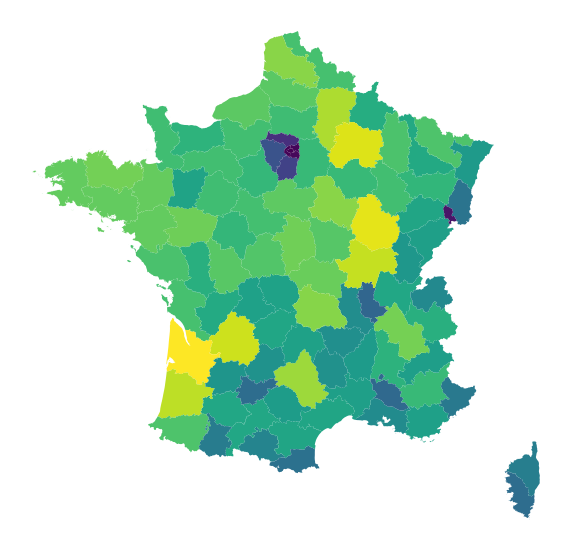

In [24]:
fig,ax = plt.subplots(figsize=(10, 10))
shp_communes[shp_communes.dep != "97"].dissolve(by='dep', aggfunc='sum').plot(ax = ax, column = "surface")
ax.set_axis_off()
ax

## Opérations sur les géométries

{{% box status=“warning” title=“Warning” icon=“fa fa-exclamation-triangle” %}}
Les données sont en système de coordonnées WGS 84 ou pseudo-Mercator (epsg: `3857`) et ne sont pas projetées. C’est un format approprié lorsqu’il s’agit d’utiliser un fonds
de carte openstreetmap, stamen, google maps, etc.

Mais ce n’est pas un
format sur lequel on désire faire des calculs car les distances sont faussées sans utiliser de projection. D’ailleurs, geopandas refusera certaines opérations
sur des données dont le crs est `3857`. On reprojete ainsi les données
dans la projection officielle pour la métropole, le Lambert 93
(epsg: 2154).
{{% /box %}}

In [25]:
communes = shp_communes.to_crs(2154)
stations = stations.to_crs(2154)

Outre la représentation graphique simplifiée,
sur laquelle nous reviendrons ultérieurement, l’intérêt principal d’utiliser
`geopandas` est l’existence de méthodes efficaces pour
manipuler la dimension spatiale. Un certain nombre proviennent du
package
[shapely](https://shapely.readthedocs.io/en/latest/manual.html#general-attributes-and-methods).

Par exemple, on peut recalculer la taille d’une commune ou d’arrondissement
avec la méthode `area` (et diviser par $10^6$ pour avoir des $km^2$ au lieu
des $m^2$):

In [26]:
communes['superficie'] = communes.area.div(10**6)
communes

id 
 nom 
 nom_m 
 insee 
 statut 
 population 
 insee_can 
 insee_arr 
 insee_dep 
 insee_reg 
 siren_epci 
 geometry 
 bbox 
 crs 
 dep 
 surface 
 superficie 
 
 
 
 
 0 
 COMMUNE_0000001269976025 
 Le Diamant 
 LE DIAMANT 
 97206 
 Commune simple 
 5511 
 NR 
 3 
 972 
 02 
 249720053 
 MULTIPOLYGON (((-6391753.798 5917890.607, -639... 
 [-6796892.81639186, 1624969.98776564, -6788212... 
 EPSG:3857 
 97 
 29.404062 
 36.143438 
 
 
 1 
 COMMUNE_0000001269976026 
 Les Anses-d'Arlet 
 LES ANSES-D'ARLET 
 97202 
 Commune simple 
 3494 
 NR 
 3 
 972 
 02 
 249720053 
 MULTIPOLYGON (((-6387446.650 5925135.253, -638... 
 [-6801724.22854182, 1626341.46982216, -6795643... 
 EPSG:3857 
 97 
 27.639002 
 33.965028 
 
 
 2 
 COMMUNE_0000001269976019 
 Rivière-Salée 
 RIVIERE-SALEE 
 97221 
 Commune simple 
 11874 
 NR 
 3 
 972 
 02 
 249720053 
 MULTIPOLYGON (((-6376797.914 5922241.198, -637... 
 [-6790993.527111, 1631234.68464338, -6781597.8... 
 EPSG:3857 
 97 
 42.512706 
 52.208095 
 
 
 3 
 COMMUNE_0000001269975998 
 Saint-Pierre 
 SAINT-PIERRE 
 97225 
 Sous-préfecture 
 4121 
 NR 
 4 
 972 
 02 
 200041788 
 MULTIPOLYGON (((-6375440.149 5963311.162, -637... 
 [-6814293.27835075, 1657968.05307498, -6805323... 
 EPSG:3857 
 97 
 41.426282 
 50.544060 
 
 
 4 
 COMMUNE_0000001269975994 
 Sainte-Marie 
 SAINTE-MARIE 
 97228 
 Commune simple 
 15487 
 NR 
 2 
 972 
 02 
 200041788 
 MULTIPOLYGON (((-6354993.090 5940000.304, -635... 
 [-6796534.21176401, 1658613.16621139, -6786313... 
 EPSG:3857 
 97 
 47.795262 
 58.324185 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 34950 
 COMMUNE_0000001400385508 
 Cilaos 
 CILAOS 
 97424 
 Commune simple 
 5538 
 16 
 2 
 974 
 04 
 249740077 
 MULTIPOLYGON (((10208698.554 514866.275, 10208... 
 [6167510.08504323, -2415138.66224137, 6179055.... 
 EPSG:3857 
 97 
 97.500269 
 298.813479 
 
 
 34951 
 COMMUNE_0000001400385492 
 Saint-André 
 SAINT-ANDRE 
 97409 
 Commune simple 
 56902 
 91 
 3 
 974 
 04 
 249740093 
 MULTIPOLYGON (((10216467.898 543266.355, 10216... 
 [6186474.83850554, -2392231.2365482, 6200549.9... 
 EPSG:3857 
 97 
 62.677716 
 191.155271 
 
 
 34952 
 COMMUNE_0000001400385498 
 Sainte-Rose 
 SAINTE-ROSE 
 97419 
 Commune simple 
 6345 
 08 
 3 
 974 
 04 
 249740093 
 MULTIPOLYGON (((10282429.738 528772.464, 10281... 
 [6194592.31952489, -2421954.15340201, 6215705.... 
 EPSG:3857 
 97 
 205.346462 
 630.109189 
 
 
 34953 
 COMMUNE_0000001400385515 
 Saint-Pierre 
 SAINT-PIERRE 
 97416 
 Sous-préfecture 
 84982 
 98 
 2 
 974 
 04 
 249740077 
 MULTIPOLYGON (((10253936.385 500836.410, 10254... 
 [6167541.02300516, -2435274.027688, 6189889.02... 
 EPSG:3857 
 97 
 111.579975 
 343.528241 
 
 
 34954 
 COMMUNE_0000001400385513 
 Saint-Joseph 
 SAINT-JOSEPH 
 97412 
 Commune simple 
 37918 
 94 
 2 
 974 
 04 
 249740085 
 MULTIPOLYGON (((10256323.261 498668.036, 10256... 
 [6187388.87754728, -2438398.99690376, 6201138.... 
 EPSG:3857 
 97 
 205.925530 
 633.893982 
 
 
 
 34955 rows × 17 columns

Une méthode qu’on utilise régulièrement est `centroid` qui, comme son nom l’indique,
recherche le centroïde de chaque polygone et transforme ainsi des données
surfaciques en données ponctuelles. Par exemple, pour
représenter approximativement les centres des villages de la
Haute-Garonne (31), on
fera

<AxesSubplot:>

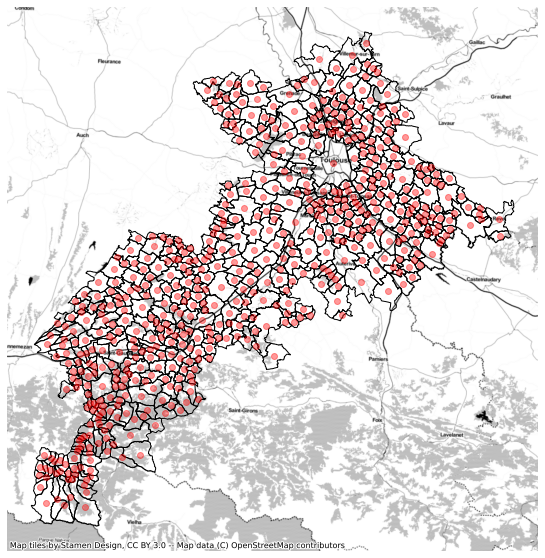

In [27]:
departement = communes[communes.dep == "31"].copy()
departement['geometry'] = departement['geometry'].centroid


ax = departement.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes[communes['dep'] == "31"].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Toner)
ax.set_axis_off()
ax

<Figure size 432x288 with 0 Axes>

# Gérer le système de projection

Précédemment, nous avons appliqué une méthode `to_crs` pour reprojeter
les données dans un système de projection différent de celui du fichier
d’origine:

``` python
communes = communes.to_crs(2154)
stations = stations.to_crs(2154)
```

Le système de projection est fondamental pour que la dimension
spatiale soit bien interprétée par `python`. Un mauvais système de représentation
fausse l’appréciation visuelle mais peut aussi entraîner des erreurs dans
les calculs sur la dimension spatiale.
Ce [post](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/geographic-vs-projected-coordinate-reference-systems-UTM/) propose de riches éléments sur le
sujet, notamment l’image suivante qui montre bien le principe d’une projection:

![Les différents types de projection](https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/spatial-projection-transformations-crs.png)

La Terre peut ainsi être représentée de multiple manière, ce qui n’est pas neutre sur la manière de se représenter
certains continents. En particulier, avec la projection Mercator, l’Afrique apparaît beaucoup moins vaste qu’elle ne l’est en réalité

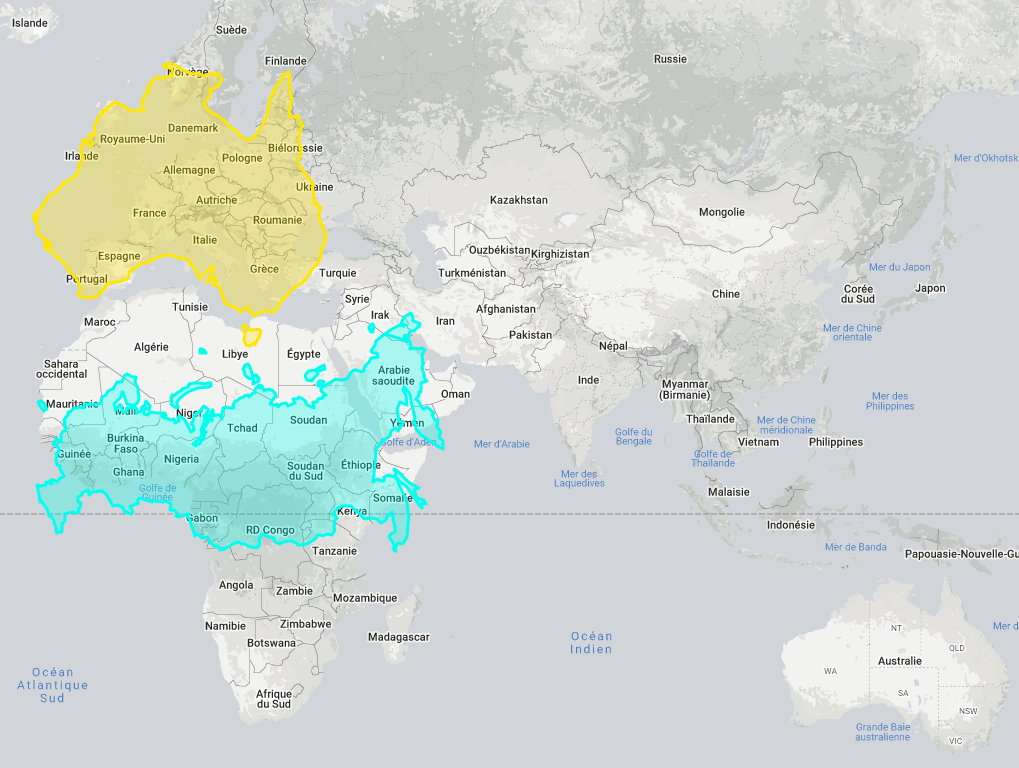
*Exemple de reprojection de pays depuis le site [thetruesize.com](https://thetruesize.com/)*

Les projections sont très nombreuses et certaines peuvent avoir une [forme suprenante](https://imgs.xkcd.com/comics/map_projections.png)

Concernant la gestion des projections avec `geopandas`,
la [documentation officielle](https://geopandas.org/projections.html) est très bien
faite sur le sujet. Elle fournit notamment l’avertissement suivant qu’il est
bon d’avoir en tête:

> Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the geopandas.read_file() command) should always include projection information. You can see an objects current CRS through the GeoSeries.crs attribute.
>
> From time to time, however, you may get data that does not include a projection. In this situation, you have to set the CRS so geopandas knows how to interpret the coordinates.

![](https://imgs.xkcd.com/comics/bad_map_projection_south_america.png)
*Image empruntée à XKCD <https://xkcd.com/2256/> qu’on peut également trouver sur <https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/>*

Pour déterminer le système de projection d’une base de données, on peut vérifier l’attribut `crs`:

In [29]:
communes.crs

<Derived Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Les deux principales méthodes pour définir le système de projection utilisé sont:

-   **`df.set_crs`**: cette commande sert à préciser quel est le système de projection utilisé, c’est-à-dire comment les coordonnées *(x,y)* sont reliées à la surface terrestre. **Cette commande ne doit pas être utilisée pour transformer le système de coordonnées, seulement pour le définir**.
-   **`df.to_crs`**: **cette commande sert à projeter les points d’une géométrie dans une autre, c’est-à-dire à recalculer les coordonnées selon un autre système de projection.**

Dans le cas particulier de production de carte avec un fond `openstreetmaps` ou une carte dynamique `leaflet`, il est nécessaire de dé-projeter les données (par exemple à partir du Lambert-93) pour atterrir dans le système non-projeté WGS 84 (code EPSG 4326). Ce site [dédié aux projections géographiques](https://epsg.io/) peut-être utile pour retrouver le système de projection d’un fichier où il n’est pas indiqué.

La définition du système de projection se fait de la manière suivante (:warning: avant de le faire, se souvenir de l’avertissement !):

``` python
communes = communes.set_crs(2154)
```

Alors que la reprojection (projection Albers: 5070) s’obtient de la manière suivante:

<AxesSubplot:>

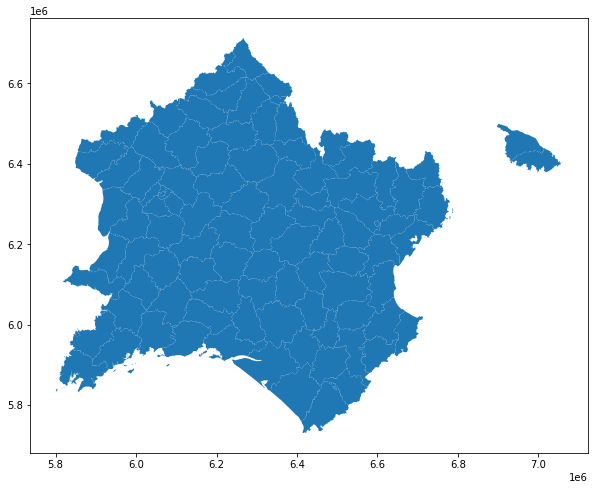

In [30]:
fig,ax = plt.subplots(figsize=(10, 10))
communes[communes.dep != "97"].dissolve(by='dep', aggfunc='sum').to_crs(5070).plot(ax = ax)
ax

<Figure size 432x288 with 0 Axes>

On le voit, cela modifie totalement la représentation de l’objet dans l’espace.
Clairement, cette projection n’est pas adaptée aux longitudes et latitudes françaises.
C’est normal, il s’agit d’une projection adaptée au continent
nord-américain (et encore, pas dans son ensemble !).

<AxesSubplot:>

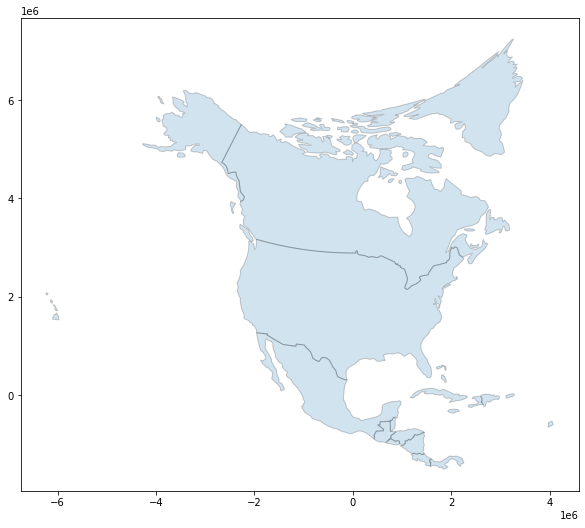

In [32]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig,ax = plt.subplots(figsize=(10, 10))
world[world.continent == "North America"].to_crs(5070).plot(alpha = 0.2, edgecolor = "k", ax = ax)
ax

<Figure size 432x288 with 0 Axes>

# Joindre des données

## Joindre des données sur des attributs

Ce type de jointure se fait entre un objet géographique et un
deuxième objet, géographique ou non. A l’exception de la question
des géométries, il n’y a pas de différence par rapport à `pandas`.

La seule différence avec `pandas` est dans la dimension géographique.
Si on désire conserver la dimension géographique, il faut faire
attention à faire:

``` python
geopandas_object.merge(pandas_object)
```

Si on utilise deux objets géographiques mais ne désire conserver qu’une seule
dimension géographique[1], on fera

``` python
geopandas_object1.merge(geopandas_object2)
```

Seule la géométrie de l’objet de gauche
sera conservée, même si on fait un *right join*.

## Prolongation possible : joindre données sur dimension géographique

{{% box status=“hint” title=“Conseil” icon=“fa fa-lightbulb” %}}
Les jointures spatiales peuvent être très gourmandes en ressources (car il peut être nécessaire de croiser toutes les géométries de `x` avec toutes les géométries de `y`). Voici deux conseils qui peuvent vous aider:

-   Il est préférable de tester les jointures géographiques sur un petit échantillon de données, pour estimer le temps et les ressources nécessaires à la réalisation de la jointure.
-   Il est parfois possible d’écrire une fonction qui réduit la taille du problème. Exemple: vous voulez déterminer dans quelle commune se situe un logement dont vous connaissez les coordonnées et le département; vous pouvez écrire une fonction qui réalise pour chaque département une jointure spatiale entre les logements situés dans ce département et les communes de ce département, puis empiler les 101 tables de sorties.
    {{% /box %}}

## Annexe

### Récupération des données depuis datagouv

Les données des limites administratives demandent donc un peu de travail pour être
importées car elles sont zippées (mais c’est un bon exercice !). Le code suivant, dont les
détails apparaîtront plus clairs après la lecture de la partie
*[webscraping](webscraping)* permet de :

1.  Télécharger les données avec `requests` dans un dossier temporaire
2.  Les dézipper avec le module `zipfile`

La fonction suivante automatise un peu le processus :

[1] Il est techniquement possible d’avoir un DataFrame comportant plusieurs
géographies. Par exemple une géométrie polygone et une géométrie point
(le centroid). C’est néanmoins souvent compliqué à gérer et donc peu
recommandable.

In [34]:
import requests
import tempfile
import zipfile

url = 'https://www.data.gouv.fr/fr/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165'
temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open("{}/{}.zip".format(dirname, destname), 'wb').write(myfile.content)
  with zipfile.ZipFile("{}/{}.zip".format(dirname, destname), 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [35]:
download_unzip(url)
communes = gpd.read_file(temporary_location + "/borders/communes-20190101.json")